In [77]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time


baseURL = "https://www.basketball-reference.com/"

def get_all_star_data(years_back=25, outfile="all_star_out.csv"):
    URL = "https://www.basketball-reference.com/allstar/"

    html = requests.get(URL)

    soup = BeautifulSoup(html.content, "html.parser")
    if soup.find('div', id="content"):
        content = soup.find('div', id="content")
    else:
        print("Failed to parse CONTENT DIV")
        print("(Likely blocked for spam)")
        return
    
    if content.find('div', id="all_all_star_games_nba"):
        allstar_div = content.find('div', id="all_all_star_games_nba")
    else:
        print("Failed to parse TOP ALL STAR DIV")
        print("(Likely blocked for spam)")
        return

    table_div = allstar_div.find('div', id="div_all_star_games_nba")
    table = table_div.find_all('tr')

    modern = table[1:years_back + 1]
    year = []
    games = []

    for rows in modern:
        data = rows.find_all('td')
        games += [data[4]]
        year += [int(data[0].text)]

    link_games = []
    for game in games:
        link_games += [game.find('a').get('href')]
    
    link_players = []
    player_yrs = []

    i = -1
    for link in link_games:
        i += 1
        curr = year[i]

        newURL = str(baseURL + link)
        html = requests.get(newURL)

        soup = BeautifulSoup(html.content, "html.parser")
        content = soup.find('div', id="content")
        teams = content.find_all('div', class_="table_wrapper")
        teams = teams[1:]

        for team in teams:
            table = team.find('table')
            body = table.find('tbody')
            rows = body.find_all('tr')
            for row in rows:
                if row.find('a'):
                    link_players += [str(row.find('a').get('href'))]
                    player_yrs += [int(curr)]

        # Forced to add pauses in order to comply with BBall Reference
        # bot scraping guidelines (forced to <20 get requests per min)
        print(str(i + 1) + " / " + str(len(link_games)) + " rosters constructed...")
        time.sleep(3)

    final_player_data = []

    i = -1
    for player in link_players:
        i += 1
        lookfor = str("per_game_stats." + str(player_yrs[i]))

        player_data = []
        newURL = str(baseURL + player)
        html = requests.get(newURL)
        soup = BeautifulSoup(html.content, "html.parser")

        meta = soup.find('div', id="info")
        meta = meta.find('div', id="meta")
        name = meta.find('h1')
        name = name.find('span').string

        player_data += [name]
        player_data += [str(player_yrs[i])]

        content = soup.find('div', id="content")        
        table = content.find('table', id="per_game_stats") # updated for new HTML of bball ref
        body = table.find('tbody')
        if body.find('tr', id=lookfor):
            year_stats = body.find('tr', id=lookfor)
            rows = year_stats.find_all('td')
            for row in rows:
                if row.find('a'):
                    player_data += [str(row.find('a').string)]
                else:
                    player_data += [str(row.string)]

        lookfor = str("advanced." + str(player_yrs[i]))
        table = content.find('table', id="advanced") # updated for new HTML of bball ref
        body = table.find('tbody')
        if body.find('tr', id=lookfor):
            year_stats = body.find('tr', id=lookfor)
            rows = year_stats.find_all('td')
            for row in rows:
                if row.find('a'):
                    player_data += [str(row.find('a').string)]
                else:
                    player_data += [str(row.string)]
        
        final_player_data += [player_data]

        print(str(i + 1) + " / " + str(len(link_players)) + " player stats compiled...")
        time.sleep(3)

    cols = ["Name", "All-Star Year", "Age", "Team", "League", "Position", "Games Played", "Games Started", "MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "AST", "TOV", "PF", "PTS", "Awards"]
    cols.extend([
        "Age", "Team", "Lg", "Pos", "G", "GS", "MP", "PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", 
        "TRB%", "AST%", "STL%", "AST%", "TOV%", "USG%", "OWS", "USG", "WS", "WS/48", 
        "OBPM", "DBPM", "BPM", "VORP", "Awards"
    ])
    
    df = pd.DataFrame(final_player_data)
    df.columns = cols
    df.to_csv(outfile)
    print("Finished Data Compilation. Storing in " + outfile)

def get_player_data_per_game(start_year=2000, outfile="playerdata_per_game.csv"):
    data = []
    curr = 2025
    years = []

    while curr >= start_year:
        years += [str(curr)]
        curr -= 1

    for year in years:
        url = str("https://www.basketball-reference.com/leagues/NBA_" + year + "_per_game.html")

        html = requests.get(url)

        soup = BeautifulSoup(html.content, "html.parser")
        content = soup.find('div', id="content")
        table_div  = content.find('div', id="div_per_game_stats")
        table_full = table_div.find('table', id="per_game_stats")
        body = table_full.find('tbody')
        player_rows = body.find_all('tr', class_=None)
        partials = body.find_all('tr', class_="partial_table")

        j = 0
        for row in player_rows:
            # Keeping track of current row for all rows
            # in case of mult. team
            j += 1

            # Converting table row to string array
            player = []

            all_data = row.find_all('td')
            player += [str(year)]
            for d in all_data:
                if d.find('a'):
                    player += [str(d.find('a').string)]
                else:
                    if d.string:
                        player += [str(d.string)]
                    else:
                        player += ["0"]

            if player[3] in ["TOT", "2TM", "3TM", "4TM"]:
                # get table head value
                check = row.find('th')
                new_team = ""

                while (len(partials) > j) and partials[j].find("a").string == player[1]:
                    new_team = partials[j].find_all('td')[2].string
                    j += 1

                # Set team var to last team of season
                player[3] = new_team

            data += [player]

        print(year + " player data collected")
        time.sleep(3)

    df = pd.DataFrame(data)
    cols = ["Year", "Name", "Age", "Team", "Position", "Games Played", "Games Started", "MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "Awards"]

    df.columns = cols
    df.to_csv(outfile)
    print("Finished Data Compilation. Storing in " + outfile)

def get_player_data_advanced(start_year=2000, outfile="playerdata_advanced.csv"):
    data = []
    curr = 2025
    years = []

    while curr >= start_year:
        years += [str(curr)]
        curr -= 1

    for year in years:
        url = str("https://www.basketball-reference.com/leagues/NBA_" + year + "_advanced.html")

        html = requests.get(url)

        soup = BeautifulSoup(html.content, "html.parser")
        content = soup.find('div', id="content")
        table_div  = content.find('div', id="div_advanced")
        table_full = table_div.find('table', id="advanced")
        body = table_full.find('tbody')
        player_rows = body.find_all('tr', class_=None)
        partials = body.find_all('tr', class_="partial_table")

        j = 0
        for row in player_rows:
            # Keeping track of current row for all rows
            # in case of mult. team
            j += 1

            # Converting table row to string array
            player = []

            all_data = row.find_all('td')
            player += [str(year)]
            for d in all_data:
                if d.find('a'):
                    player += [str(d.find('a').string)]
                else:
                    if d.string:
                        player += [str(d.string)]
                    else:
                        player += ["0"]

            if player[3] in ["TOT", "2TM", "3TM", "4TM"]:
                # get table head value
                check = row.find('th')
                new_team = ""

                while (len(partials) > j) and partials[j].find("a").string == player[1]:
                    new_team = partials[j].find_all('td')[2].string
                    j += 1

                # Set team var to last team of season
                player[3] = new_team

            data += [player]

        print(year + " player data collected")
        time.sleep(3)

    df = pd.DataFrame(data)
    cols = ["Year", "Name", "Age", "Team", "Pos", "G", "GS", "MP", "PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", 
        "TRB%", "AST%", "STL%", "AST%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", 
        "OBPM", "DBPM", "BPM", "VORP", "Awards"
    ]
    df.columns = cols
    df.to_csv(outfile)
    print("Finished Data Compilation. Storing in " + outfile)
# get_player_data_per_game()
# get_player_data_advanced()
# get_all_star_data()

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Load Data
all_star_df = pd.read_csv("all_star_out.csv")
adv_stats_df = pd.read_csv("playerdata_advanced.csv")
per_game_df = pd.read_csv("playerdata_per_game.csv")

# Ensure consistent column names
adv_stats_df.rename(columns={"Pos": "Position"}, inplace=True)

# Merge datasets on Year + Name
merged_df = per_game_df.merge(adv_stats_df, on=["Year", "Name", "Age", "Team", "Position", "G", "GS"], suffixes=("_per", "_adv"))

# Create binary label for All-Star selection
all_star_df["All_Star"] = 1
all_star_df = all_star_df[["Name", "Year", "All_Star"]]

# Merge with All-Star labels
merged_df = merged_df.merge(all_star_df, on=["Year", "Name"], how="left")
merged_df = merged_df[merged_df["Year"] != 2025]  # Drop 2025 data (rising all star)
merged_df["All_Star"].fillna(0, inplace=True)  # Non-All-Stars get label 0

# Select 500 All-Stars
all_stars = merged_df[(merged_df["All_Star"] == 1) & (merged_df["G"] >= 30)].sample(500, random_state=42)

# Select 500 Non-All-Stars (must have played at least 65 games)
non_all_stars = merged_df[(merged_df["All_Star"] == 0) & (merged_df["G"] >= 30)].sample(500, random_state=42)

# Define feature sets
per_game_features = ["MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
adv_features = ["PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "AST%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", "OBPM", "DBPM", "BPM", "VORP"]

# Final dataset
merged_df = pd.concat([all_stars, non_all_stars]).sample(frac=1, random_state=42)  # Shuffle
final_df = pd.concat([all_stars, non_all_stars]).sample(frac=1, random_state=42)  # Shuffle
features_to_normalize = per_game_features + adv_features
scaler = MinMaxScaler()
final_df[features_to_normalize] = scaler.fit_transform(final_df[features_to_normalize])


# Train-Test Split
train_df, test_df = train_test_split(final_df, test_size=0.3, random_state=446)
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)


# Train Logistic Regression Models
X_train_per = train_df[per_game_features]
y_train = train_df["All_Star"]
X_test_per = test_df[per_game_features]
y_test = test_df["All_Star"]

X_train_adv = train_df[adv_features]
X_test_adv = test_df[adv_features]

model_per = LogisticRegression(max_iter=10000)
model_adv = LogisticRegression(max_iter=10000)

model_per.fit(X_train_per, y_train)
model_adv.fit(X_train_adv, y_train)

# Predictions
y_pred_per = model_per.predict(X_test_per)
y_pred_adv = model_adv.predict(X_test_adv)

# Compare Accuracy
acc_per = accuracy_score(y_test, y_pred_per)
acc_adv = accuracy_score(y_test, y_pred_adv)

print(f"Per Game Model Accuracy: {acc_per:.4f}")
print(f"Advanced Stats Model Accuracy: {acc_adv:.4f}")


Per Game Model Accuracy: 0.9100
Advanced Stats Model Accuracy: 0.9167


/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_14218/1089007980.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["All_Star"].fillna(0, inplace=True)  # Non-All-Stars get label 0


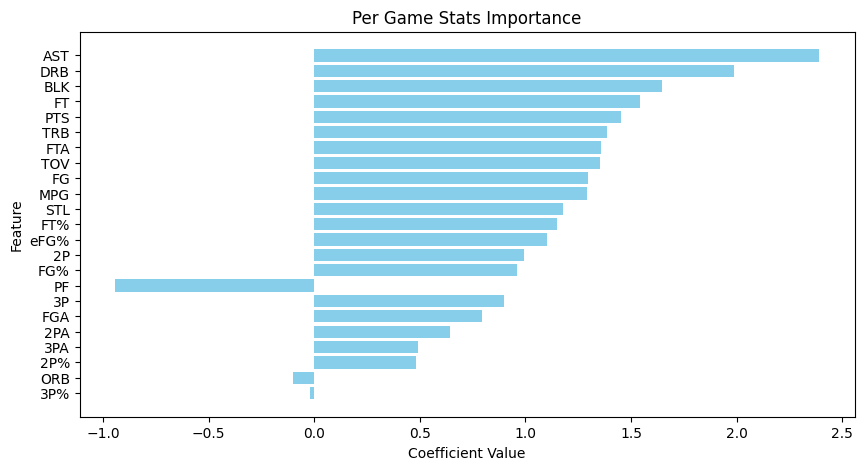

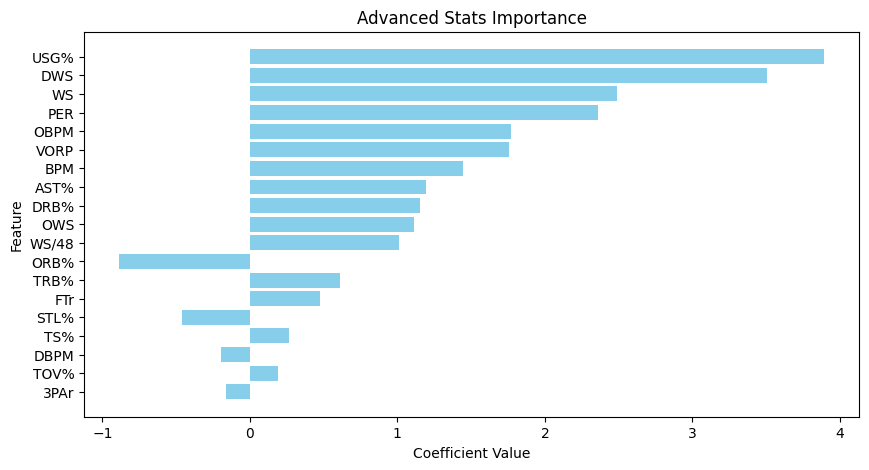

In [79]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title):
    coef = model.coef_[0]
    importance = pd.DataFrame({"Feature": feature_names, "Coefficient": coef})
    importance["Abs_Coefficient"] = np.abs(importance["Coefficient"])
    importance = importance.sort_values(by="Abs_Coefficient", ascending=False)

    plt.figure(figsize=(10, 5))
    plt.barh(importance["Feature"], importance["Coefficient"], color="skyblue")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(model_per, per_game_features, "Per Game Stats Importance")
plot_feature_importance(model_adv, adv_features, "Advanced Stats Importance")


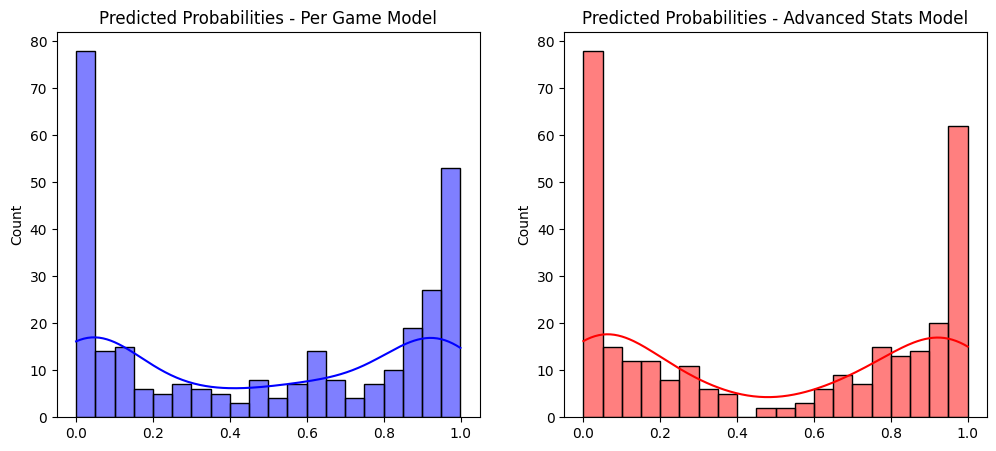

In [80]:
import seaborn as sns

# Get predicted probabilities
y_prob_per = model_per.predict_proba(X_test_per)[:, 1]
y_prob_adv = model_adv.predict_proba(X_test_adv)[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_prob_per, bins=20, kde=True, color="blue")
plt.title("Predicted Probabilities - Per Game Model")

plt.subplot(1, 2, 2)
sns.histplot(y_prob_adv, bins=20, kde=True, color="red")
plt.title("Predicted Probabilities - Advanced Stats Model")

plt.show()

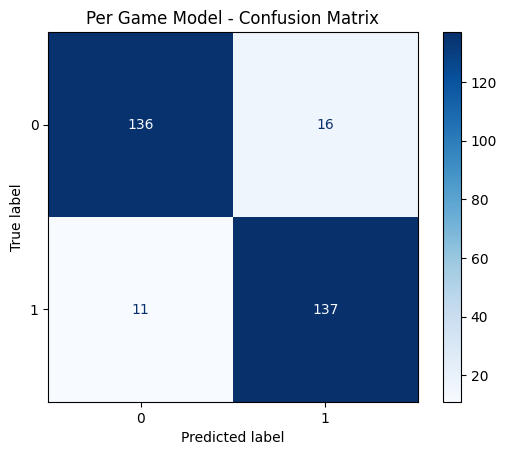

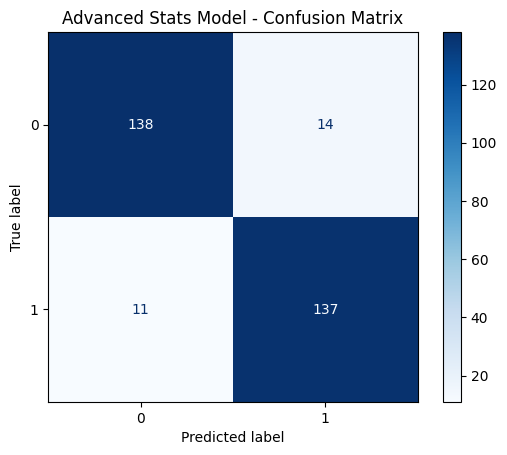

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_per, "Per Game Model - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_adv, "Advanced Stats Model - Confusion Matrix")


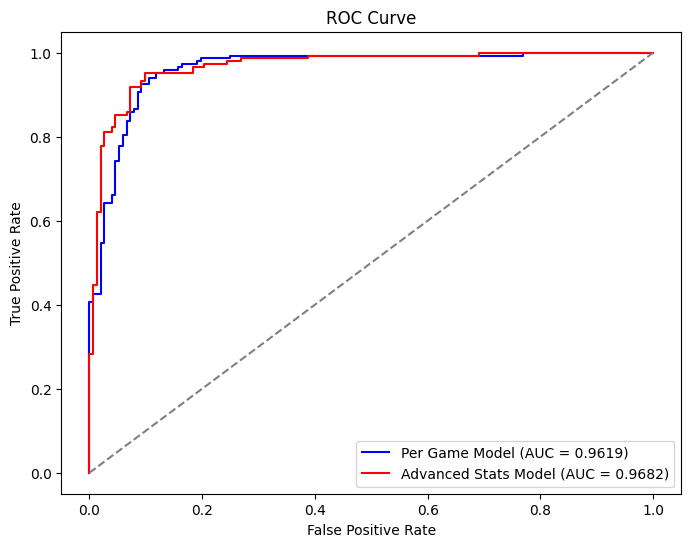

In [82]:
from sklearn.metrics import roc_curve, auc

fpr_per, tpr_per, _ = roc_curve(y_test, y_prob_per)
fpr_adv, tpr_adv, _ = roc_curve(y_test, y_prob_adv)

auc_per = auc(fpr_per, tpr_per)
auc_adv = auc(fpr_adv, tpr_adv)

plt.figure(figsize=(8, 6))
plt.plot(fpr_per, tpr_per, label=f"Per Game Model (AUC = {auc_per:.4f})", color="blue")
plt.plot(fpr_adv, tpr_adv, label=f"Advanced Stats Model (AUC = {auc_adv:.4f})", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [83]:
import numpy as np

# Add predicted probabilities and predictions to the test set
test_df["Prob_Per"] = model_per.predict_proba(X_test_per)[:, 1]
test_df["Prob_Adv"] = model_adv.predict_proba(X_test_adv)[:, 1]

test_df["Pred_Per"] = model_per.predict(X_test_per)
test_df["Pred_Adv"] = model_adv.predict(X_test_adv)

# Find most uncertain players (probability close to 50%)
test_df["Uncertainty_Per"] = np.abs(test_df["Prob_Per"] - 0.5)
test_df["Uncertainty_Adv"] = np.abs(test_df["Prob_Adv"] - 0.5)

most_uncertain_per = test_df.nsmallest(10, "Uncertainty_Per")
most_uncertain_adv = test_df.nsmallest(10, "Uncertainty_Adv")

# Confident incorrect predictions (False Positives & False Negatives)
wrong_preds_per_high = test_df[(test_df["Pred_Per"] != test_df["All_Star"]) & (test_df["Prob_Per"] > 0.7)]  # Overconfident wrong
wrong_preds_per_low = test_df[(test_df["Pred_Per"] != test_df["All_Star"]) & (test_df["Prob_Per"] < 0.3)]  # Underconfident wrong

wrong_preds_adv_high = test_df[(test_df["Pred_Adv"] != test_df["All_Star"]) & (test_df["Prob_Adv"] > 0.7)]
wrong_preds_adv_low = test_df[(test_df["Pred_Adv"] != test_df["All_Star"]) & (test_df["Prob_Adv"] < 0.3)]

# Find players where the two models strongly disagreed
disagreements = test_df[test_df["Pred_Per"] != test_df["Pred_Adv"]]

# Select columns to display (keep key stats)
display_cols = ["Year", "Name", "Age", "G", "All_Star", "Prob_Per", "Prob_Adv", "Pred_Per", "Pred_Adv"] + per_game_features + adv_features

# Keep only the relevant columns from merged_df (avoid duplicate Year, Name)
original_stats = merged_df[["Year", "Name"] + per_game_features + adv_features].set_index(["Year", "Name"])

# Function to retrieve original stats for a given subset of test_df
def get_original_stats(df_subset):
    return df_subset.set_index(["Year", "Name"])[["All_Star", "Prob_Per", "Prob_Adv", "Pred_Per", "Pred_Adv"]]\
                    .join(original_stats, on=["Year", "Name"]).reset_index()


# Get unnormalized stats for each category
most_uncertain_per = get_original_stats(most_uncertain_per)
print(most_uncertain_per)
most_uncertain_adv = get_original_stats(most_uncertain_adv)

wrong_preds_per_high = get_original_stats(wrong_preds_per_high.head(10))
wrong_preds_per_low = get_original_stats(wrong_preds_per_low.head(10))

wrong_preds_adv_high = get_original_stats(wrong_preds_adv_high.head(10))
wrong_preds_adv_low = get_original_stats(wrong_preds_adv_low.head(10))

disagreements = get_original_stats(disagreements.head(10))

# Save insights to a text file
with open("model_insights.txt", "w") as f:
    f.write("\nMost Uncertain Predictions (Per Game Model):\n")
    f.write(most_uncertain_per.to_string(index=False) + "\n\n")

    f.write("\nMost Uncertain Predictions (Advanced Stats Model):\n")
    f.write(most_uncertain_adv.to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Per Game Model) - High Confidence:\n")
    f.write(wrong_preds_per_high.to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Per Game Model) - Low Confidence:\n")
    f.write(wrong_preds_per_low.to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Advanced Stats Model) - High Confidence:\n")
    f.write(wrong_preds_adv_high.to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Advanced Stats Model) - Low Confidence:\n")
    f.write(wrong_preds_adv_low.to_string(index=False) + "\n\n")

    f.write("\nPlayers Where Models Disagreed:\n")
    f.write(disagreements.to_string(index=False) + "\n\n")

print("Insights saved to model_insights.txt")



   Year              Name  All_Star  Prob_Per  Prob_Adv  Pred_Per  Pred_Adv  \
0  2013     Zach Randolph       1.0  0.499443  0.629025       0.0       1.0   
1  2013     Kevin Garnett       1.0  0.497565  0.700667       0.0       1.0   
2  2006       Sam Cassell       0.0  0.511071  0.774125       1.0       1.0   
3  2005   Stephen Jackson       0.0  0.487637  0.262397       0.0       0.0   
4  2003  Latrell Sprewell       0.0  0.473268  0.141352       0.0       0.0   
5  2017  Danilo Gallinari       0.0  0.532944  0.315572       1.0       0.0   
6  2018     Klay Thompson       1.0  0.540337  0.214296       1.0       0.0   
7  2004   Jamaal Magloire       1.0  0.459509  0.375690       0.0       0.0   
8  2005       Ben Wallace       1.0  0.457648  0.652976       0.0       1.0   
9  2009     Rashard Lewis       1.0  0.542970  0.791728       1.0       1.0   

    MPG   FG   FGA  ...  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  \
0  34.3  6.2  13.5  ...  11.5  23.1  3.2  4.7  7.9  


=== TOP 24 PREDICTED ALL-STARS BASED ON PER-GAME STATS ===


,Name,Team,Position,AllStar_Prob_PerGame,PTS,TRB,AST
0,Shai Gilgeous-Alexander,OKC,PG,1.0,32.9,5.1,6.3
251,Sam Hauser,BOS,PF,1.0,8.2,3.1,0.9
249,Brandon Williams,DAL,PG,1.0,8.3,1.7,2.4
248,Peyton Watson,DEN,SF,1.0,8.3,3.4,1.5
247,Cason Wallace,OKC,SG,1.0,8.3,3.4,2.5
246,Brandon Clarke,MEM,PF,1.0,8.3,5.1,1.0
244,Jared Butler,NaN,SG,1.0,8.3,1.7,3.4
242,Johnny Juzang,UTA,SG,1.0,8.4,2.8,1.0
241,Jaden Hardy,DAL,SG,1.0,8.4,1.5,1.3
240,Keon Ellis,SAC,SG,1.0,8.4,2.6,1.5



=== TOP 24 PREDICTED ALL-STARS BASED ON ADVANCED STATS ===


,Name,Team,Position,AllStar_Prob_Advanced,PER,WS,VORP
0,Shai Gilgeous-Alexander,OKC,PG,1.0,30.8,15.9,8.3
308,Jamison Battle,TOR,SF,1.0,10.7,1.4,0.0
305,DaQuan Jeffries,CHO,SG,1.0,8.1,0.6,-0.6
304,Ron Holland,DET,SF,1.0,11.2,1.7,-0.3
303,Thomas Bryant,NaN,C,1.0,17.5,2.7,0.6
302,Vasilije Micić,NaN,PG,1.0,6.5,-0.9,-1.0
301,Josh Okogie,NaN,SG,1.0,16.4,1.2,0.5
299,Jamal Shead,TOR,PG,1.0,9.9,0.8,-0.6
298,Trayce Jackson-Davis,GSW,C,1.0,18.3,3.2,0.8
297,Eric Gordon,PHI,SG,1.0,10.9,0.8,0.1



=== MODEL COMPARISON ===
Total players predicted as All-Stars (Per Game model): 396
Total players predicted as All-Stars (Advanced model): 396

Players predicted as All-Stars by BOTH models: 396


,Name,Team,Position,AllStar_Prob_PerGame,AllStar_Prob_Advanced,PTS,PER
0,Shai Gilgeous-Alexander,OKC,PG,1.000000,1.0,32.9,30.8
1,Giannis Antetokounmpo,MIL,PF,1.000000,1.0,30.2,29.8
2,Nikola Jokić,DEN,C,1.000000,1.0,29.3,32.0
3,Luka Dončić,NaN,PG,1.000000,1.0,27.8,23.6
4,Anthony Edwards,MIN,SG,1.000000,1.0,27.2,19.6
...,...,...,...,...,...,...,...
501,Alex Len,NaN,C,1.000000,1.0,1.6,11.1
503,Johnny Furphy,IND,SG,0.999992,1.0,1.6,8.9
505,Tristan Thompson,CLE,C,1.000000,1.0,1.6,9.6
507,Jordan Walsh,BOS,PF,0.999999,1.0,1.6,7.3


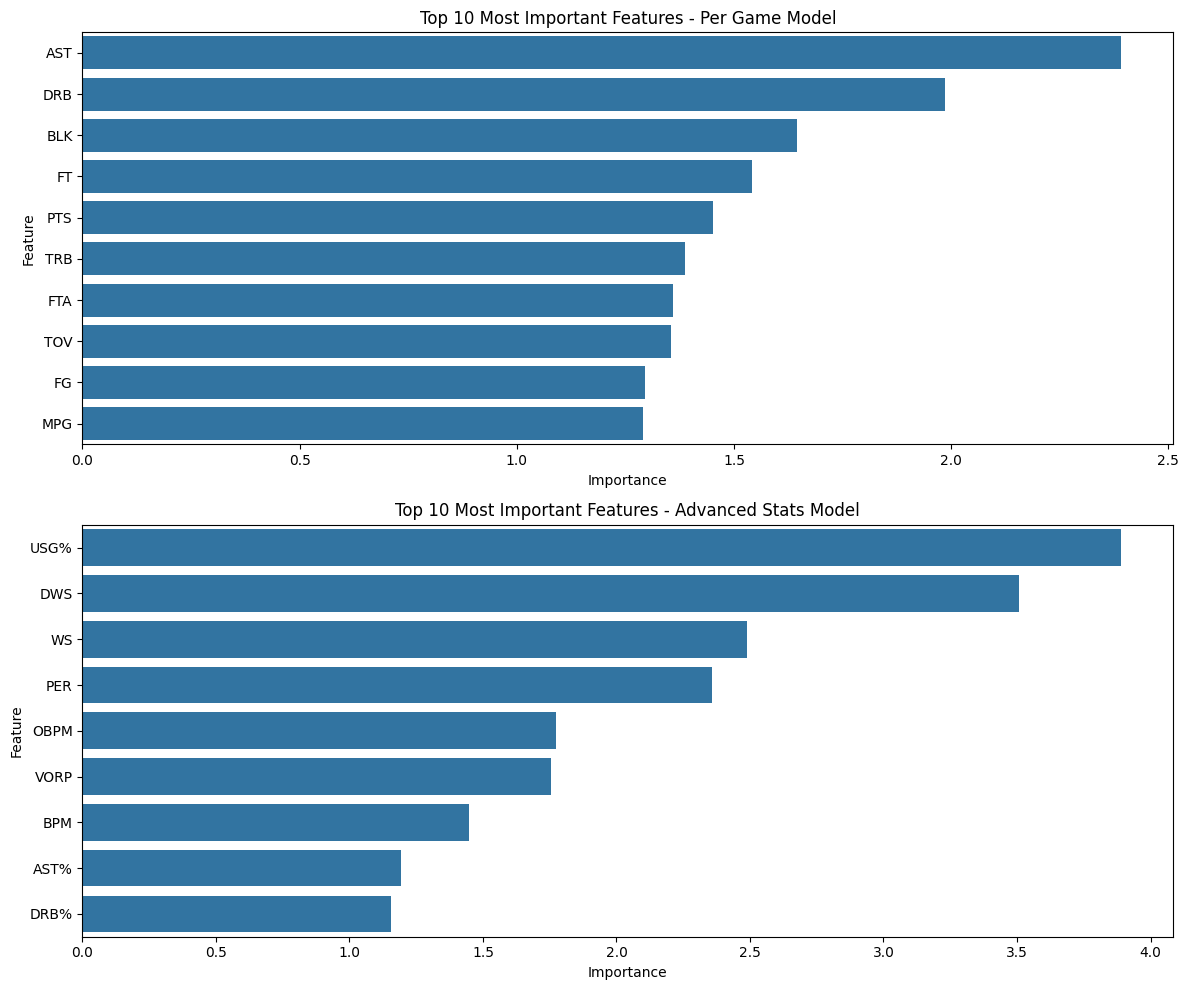

In [84]:
# Load the trained models and make predictions for 2025
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your datasets
per_game_df = pd.read_csv("playerdata_per_game.csv")
adv_stats_df = pd.read_csv("playerdata_advanced.csv")

# Ensure consistent column names
adv_stats_df.rename(columns={"Pos": "Position"}, inplace=True)

# Merge datasets for 2025 data
merged_df = per_game_df.merge(adv_stats_df, on=["Year", "Name", "Age", "Team", "Position", "G", "GS"], suffixes=("_per", "_adv"))

# Filter for 2025 season data only
data_2025 = merged_df[merged_df["Year"] == 2025]

# Filter to include only players with at least 30 games played
data_2025 = data_2025[data_2025["G"] >= 30]

# Define feature sets (same as in your training code)
per_game_features = ["MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
adv_features = ["PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "AST%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", "OBPM", "DBPM", "BPM", "VORP"]

# Make predictions for 2025
X_2025_per = data_2025[per_game_features]
X_2025_adv = data_2025[adv_features]

# Get probabilities instead of just binary predictions
prob_per = model_per.predict_proba(X_2025_per)[:, 1]  # Probability of being an All-Star
prob_adv = model_adv.predict_proba(X_2025_adv)[:, 1]

# Add predictions to the dataframe
data_2025['AllStar_Prob_PerGame'] = prob_per
data_2025['AllStar_Prob_Advanced'] = prob_adv
data_2025['AllStar_Pred_PerGame'] = (prob_per >= 0.7).astype(int)
data_2025['AllStar_Pred_Advanced'] = (prob_adv >= 0.7).astype(int)

# Display top 24 predicted All-Stars (similar to actual All-Star game roster size)
print("\n=== TOP 24 PREDICTED ALL-STARS BASED ON PER-GAME STATS ===")
top_per_game = data_2025.sort_values('AllStar_Prob_PerGame', ascending=False).head(24)
display(top_per_game[['Name', 'Team', 'Position', 'AllStar_Prob_PerGame', 'PTS', 'TRB', 'AST']])

print("\n=== TOP 24 PREDICTED ALL-STARS BASED ON ADVANCED STATS ===")
top_advanced = data_2025.sort_values('AllStar_Prob_Advanced', ascending=False).head(24)
display(top_advanced[['Name', 'Team', 'Position', 'AllStar_Prob_Advanced', 'PER', 'WS', 'VORP']])

# Compare models
print("\n=== MODEL COMPARISON ===")
total_predicted_per = data_2025['AllStar_Pred_PerGame'].sum()
total_predicted_adv = data_2025['AllStar_Pred_Advanced'].sum()
print(f"Total players predicted as All-Stars (Per Game model): {total_predicted_per}")
print(f"Total players predicted as All-Stars (Advanced model): {total_predicted_adv}")

# Find players predicted by both models
both_models = data_2025[(data_2025['AllStar_Pred_PerGame'] == 1) & (data_2025['AllStar_Pred_Advanced'] == 1)]
print(f"\nPlayers predicted as All-Stars by BOTH models: {len(both_models)}")
display(both_models[['Name', 'Team', 'Position', 'AllStar_Prob_PerGame', 'AllStar_Prob_Advanced', 'PTS', 'PER']])


# Feature importance analysis
plt.figure(figsize=(12, 10))

# Per game model feature importance
plt.subplot(2, 1, 1)
per_game_importance = pd.DataFrame({
    'Feature': per_game_features,
    'Importance': np.abs(model_per.coef_[0])
})
per_game_importance = per_game_importance.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=per_game_importance.head(10))
plt.title('Top 10 Most Important Features - Per Game Model')

# Advanced stats model feature importance
plt.subplot(2, 1, 2)
adv_importance = pd.DataFrame({
    'Feature': adv_features,
    'Importance': np.abs(model_adv.coef_[0])
})
adv_importance = adv_importance.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=adv_importance.head(10))
plt.title('Top 10 Most Important Features - Advanced Stats Model')

plt.tight_layout()
plt.show()

# Optional: Save the 2025 predictions to CSV
data_2025[['Name', 'Team', 'Position', 'AllStar_Prob_PerGame', 'AllStar_Prob_Advanced', 
           'AllStar_Pred_PerGame', 'AllStar_Pred_Advanced', 'PTS', 'TRB', 'AST', 'PER', 'WS', 'VORP']].to_csv('allstar_predictions_2025.csv', index=False)

In [85]:
# Train separate models for AST and USG and evaluate performance
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load data
train_df = pd.read_csv("new_train_dataset.csv")
test_df = pd.read_csv("new_test_dataset.csv")

# Define features for separate models
AST_feature = ["AST"]
USG_feature = ["USG%"]

# Train AST model
X_train_AST = train_df[AST_feature]
X_test_AST = test_df[AST_feature]
y_train = train_df["All_Star"]
y_test = test_df["All_Star"]

model_AST = LogisticRegression(max_iter=10000)
model_AST.fit(X_train_AST, y_train)
y_pred_AST = model_AST.predict(X_test_AST)

# Train USG model
X_train_USG = train_df[USG_feature]
X_test_USG = test_df[USG_feature]

model_USG = LogisticRegression(max_iter=10000)
model_USG.fit(X_train_USG, y_train)
y_pred_USG = model_USG.predict(X_test_USG)

# Print accuracies
print(f"AST-only Model Accuracy: {accuracy_score(y_test, y_pred_AST):.4f}")
print(f"USG-only Model Accuracy: {accuracy_score(y_test, y_pred_USG):.4f}")

# Classification reports
print("\n=== AST MODEL CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_AST))

print("\n=== USG MODEL CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_USG))

# Print model coefficients
print(f"\nAST Model: coef = {model_AST.coef_[0][0]:.4f}, intercept = {model_AST.intercept_[0]:.4f}")
print(f"USG Model: coef = {model_USG.coef_[0][0]:.4f}, intercept = {model_USG.intercept_[0]:.4f}")

# Load 2025 data
per_game_df = pd.read_csv("playerdata_per_game.csv")
adv_stats_df = pd.read_csv("playerdata_advanced.csv")
adv_stats_df.rename(columns={"Pos": "Position"}, inplace=True)
merged_df = per_game_df.merge(adv_stats_df, on=["Year", "Name", "Age", "Team", "Position", "G", "GS"], suffixes=("_per", "_adv"))
data_2025 = merged_df[(merged_df["Year"] == 2025) & (merged_df["G"] >= 30)]

# Make predictions for 2025
X_2025_AST = data_2025[AST_feature]
X_2025_USG = data_2025[USG_feature]

# Get probabilities
prob_AST = model_AST.predict_proba(X_2025_AST)[:, 1]
prob_USG = model_USG.predict_proba(X_2025_USG)[:, 1]

# Add to dataframe
data_2025['AllStar_Prob_AST'] = prob_AST
data_2025['AllStar_Prob_USG'] = prob_USG
data_2025['AllStar_Pred_AST'] = (prob_AST >= 0.5).astype(int)
data_2025['AllStar_Pred_USG'] = (prob_USG >= 0.5).astype(int)

# Display top 10 predicted All-Stars from each model
print("\n=== TOP 10 PREDICTED ALL-STARS (AST MODEL) ===")
top_AST = data_2025.sort_values('AllStar_Prob_AST', ascending=False).head(10)
print(top_AST[['Name', 'Team', 'Position', 'AllStar_Prob_AST', 'AST']].to_string(index=False))

print("\n=== TOP 10 PREDICTED ALL-STARS (USG MODEL) ===")
top_USG = data_2025.sort_values('AllStar_Prob_USG', ascending=False).head(10)
print(top_USG[['Name', 'Team', 'Position', 'AllStar_Prob_USG', 'USG%']].to_string(index=False))

# Total predicted all-stars
print(f"\nTotal predicted All-Stars (AST model): {data_2025['AllStar_Pred_AST'].sum()}")
print(f"Total predicted All-Stars (USG model): {data_2025['AllStar_Pred_USG'].sum()}")

AST-only Model Accuracy: 0.7200
USG-only Model Accuracy: 0.8167

=== AST MODEL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       152
           1       0.75      0.65      0.70       148

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300


=== USG MODEL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       152
           1       0.79      0.86      0.82       148

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300


AST Model: coef = 6.4496, intercept = -1.7494
USG Model: coef = 8.5013, intercept = -3.9200

=== TOP 10 PREDICTED ALL-STARS (AST MODEL) ===
                   Name Team Position  AllStar_Prob_AST  AS

/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_14218/111546825.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2025['AllStar_Prob_AST'] = prob_AST
/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_14218/111546825.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2025['AllStar_Prob_USG'] = prob_USG
/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_14218/111546825.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [86]:
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score


# Load data (using your existing code)
train_df = pd.read_csv("new_train_dataset.csv")
test_df = pd.read_csv("new_test_dataset.csv")

# Now let's build a comprehensive model with all metrics
# Identify non-feature columns
per_game_features = ["MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
adv_features = ["PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "AST%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", "OBPM", "DBPM", "BPM", "VORP"]

# Get all available feature columns (both standard and advanced stats)
all_features = [col for col in train_df.columns if col in per_game_features or col in adv_features]

print(f"\nTotal features for comprehensive model: {len(all_features)}")
print("Features included:", all_features)

# Prepare data for comprehensive model
X_train_all = train_df[all_features]
X_test_all = test_df[all_features]


# Train comprehensive model
model_all = LogisticRegression(max_iter=10000, C=0.1)  # C=0.1 adds some regularization
model_all.fit(X_train_all, y_train)
y_pred_all = model_all.predict(X_test_all)
y_prob_all = model_all.predict_proba(X_test_all)[:, 1]

# Evaluate comprehensive model
print("\n=== COMPREHENSIVE MODEL EVALUATION ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_all):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_all):.4f}")
print("\n=== COMPREHENSIVE MODEL CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_all))


# Load 2025 data and make predictions (similar to your code)
per_game_df = pd.read_csv("playerdata_per_game.csv")
adv_stats_df = pd.read_csv("playerdata_advanced.csv")
adv_stats_df.rename(columns={"Pos": "Position"}, inplace=True)
merged_df = per_game_df.merge(adv_stats_df, on=["Year", "Name", "Age", "Team", "Position", "G", "GS"], suffixes=("_per", "_adv"))
data_2025 = merged_df[(merged_df["Year"] == 2025) & (merged_df["G"] >= 30)]

# Check if all required features are available in 2025 data
X_2025_all = data_2025[all_features]


# Make predictions with all models
prob_AST = model_AST.predict_proba(data_2025[AST_feature])[:, 1]
prob_USG = model_USG.predict_proba(data_2025[USG_feature])[:, 1]
prob_all = model_all.predict_proba(X_2025_all)[:, 1]

data_2025['AllStar_Prob_ALL'] = prob_all
data_2025['AllStar_Pred_ALL'] = (prob_all >= 0.5).astype(int)

# Display top 15 predicted All-Stars from the comprehensive model
print("\n=== TOP 15 PREDICTED ALL-STARS (COMPREHENSIVE MODEL) ===")
top_all = data_2025.sort_values('AllStar_Prob_ALL', ascending=False).head(15)
display_cols = ['Name', 'Team', 'Position', 'AllStar_Prob_ALL', 'AllStar_Prob_AST', 'AllStar_Prob_USG', 'PTS', 'TRB', 'AST', 'AST', 'STL', 'PER', 'WS', 'VORP']
display_cols = [col for col in display_cols if col in top_all.columns]
print(top_all[display_cols].to_string(index=False))

# Compare predictions between models
print(f"Total predicted All-Stars (Comprehensive model): {data_2025['AllStar_Pred_ALL'].sum()}")


Total features for comprehensive model: 42
Features included: ['MPG', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

=== COMPREHENSIVE MODEL EVALUATION ===
Accuracy: 0.9267
ROC AUC: 0.9692

=== COMPREHENSIVE MODEL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       152
           1       0.91      0.95      0.93       148

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


=== TOP 15 PREDICTED ALL-STARS (COMPREHENSIVE MODEL) ===
                   Name Team Position  AllStar_Prob_ALL  PTS  TRB  AST  AST  STL  PER   WS  VORP
Shai Gilgeous-Alexander  OKC

/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_14218/634515361.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2025['AllStar_Prob_ALL'] = prob_all
/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_14218/634515361.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2025['AllStar_Pred_ALL'] = (prob_all >= 0.5).astype(int)


In [87]:
import time
import pandas as pd
from trendspy import Trends

# Initialize Google Trends API
tr = Trends(request_delay=4.0)

# Function to fetch relative search score
def get_trend_score(player_name, year):
    query = [player_name, "LeBron James"]
    timeframe = f"{year}-01-01 {year}-12-31"  # Full year data
    try:
        df = tr.interest_over_time(query, timeframe=timeframe)
        if df.empty or "LeBron James" not in df or player_name not in df:
            return None  # No data found
        player_avg = df[player_name].mean()
        lebron_avg = df["LeBron James"].mean()
        return player_avg / lebron_avg if lebron_avg > 0 else None
    except Exception as e:
        print(f"Error fetching trend for {player_name} ({year}): {e}")
        return None

print(get_trend_score("Lebron James", 2005))
# # Get unique (Year, Name) pairs
# players = merged_df[["Year", "Name"]].drop_duplicates()

# # Store trend scores
# trend_scores = {}
# for _, row in players.iterrows():
#     year, name = row["Year"], row["Name"]
#     trend_scores[(year, name)] = get_trend_score(name, year)
#     time.sleep(2)  # Delay to avoid rate limiting

# # Convert dictionary to DataFrame
# trend_df = pd.DataFrame(list(trend_scores.items()), columns=["Year_Name", "Trend_Score"])
# trend_df[["Year", "Name"]] = pd.DataFrame(trend_df["Year_Name"].tolist(), index=trend_df.index)
# trend_df.drop(columns=["Year_Name"], inplace=True)

# # Merge with merged_df
# merged_df = merged_df.merge(trend_df, on=["Year", "Name"], how="left")

print("Added Google Trends Score to merged_df.")


1.0
Added Google Trends Score to merged_df.


Model with Trend_Score Accuracy: 0.7667


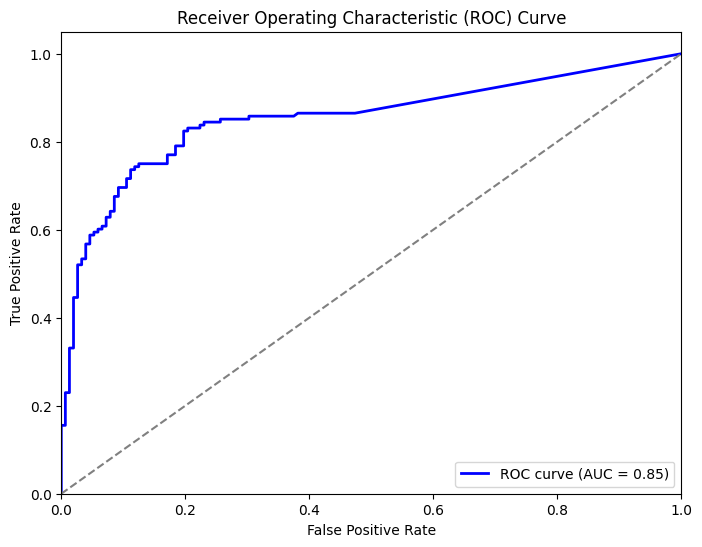

In [89]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define Trend_Score as the only feature
trend_feature = ["Trend_Score"]

# Replace NaN values with zeros
train_df[trend_feature] = train_df[trend_feature].fillna(0)
test_df[trend_feature] = test_df[trend_feature].fillna(0)

# Normalize Trend_Score
scaler = MinMaxScaler()
X_train_trend = scaler.fit_transform(train_df[trend_feature])
X_test_trend = scaler.transform(test_df[trend_feature])

# Save normalized datasets
normalized_train_df = train_df.copy()
normalized_test_df = test_df.copy()

normalized_train_df[trend_feature] = X_train_trend
normalized_test_df[trend_feature] = X_test_trend

normalized_train_df.to_csv("normalized_train_dataset.csv", index=False)
normalized_test_df.to_csv("normalized_test_dataset.csv", index=False)

# Train logistic regression model with only Trend_Score
model_trend = LogisticRegression(max_iter=10000)
model_trend.fit(X_train_trend, train_df["All_Star"])

# Predictions
y_pred_trend = model_trend.predict(X_test_trend)
y_prob_trend = model_trend.predict_proba(X_test_trend)[:, 1]

# Accuracy
acc_trend = accuracy_score(test_df["All_Star"], y_pred_trend)
print(f"Model with Trend_Score Accuracy: {acc_trend:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_df["All_Star"], y_prob_trend)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()